In [20]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from transformers import (GPT2Tokenizer, GPT2Model, 
                          set_seed,
                          training_args,
                          trainer,
                          GPT2Config,
                          get_cosine_schedule_with_warmup,
                          GPT2ForSequenceClassification)

set_seed(123)
epochs=4
batch_size = 32


# Numero massimo della sequenza
# La sequenza <80 avrà del padding, la sequenza >80 sarà troncata
max_length = 80

# Usiamo la cpu se la gpu non viene trova
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Nome del trasformers model pre-allenato
model_name_or_path = 'gpt2'

# Dizionario delle etichette e il loro ID
labels_ids = {'BPMAI': 0, 'Camunda':1}

# Numero di etichette che stiamo utilizzando
n_labels = len(labels_ids)

In [21]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

%run "./support_functions.ipynb"


#Creazione di un Dataset pytorch per il caricamento dei dati multidimensionali
class BPMNDomainDataset(Dataset):
    
    def __init__(self, path):

        # Prima di tutto controlliamo che il path esista
        if not os.path.isfile(path):
            # Se il path non è valido allora solleviamo un'eccezione
            raise ValueError('Invalid `path` variable! Needs to be a file')
        
        # Carico il file .csv
        self.df = pd.read_csv(path, sep=';', engine='python', encoding=get_file_encoding(path))

        # Estraggo le etichette e i dominii di appartenenza
        self.descriptions = self.df['Labels'].to_list()
        self.domains = self.df['CollectionName'].to_list()

        # Flatten the list of labels
        self.flattened_domains = [label for sublist in self.domains for label in sublist.split(',')]    
        # Ottengo il numero di righe
        self.n_examples = len(self.descriptions)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text': self.descriptions[item], 'label': self.flattened_domains[item]}

#Prepara i dati in modo che possano essere utilizzati efficacemente 
#durante l'addestramento di un modello GPT-2 per la classificazione di sequenze.
class Gpt2ClassificationCollator(object):
    """
    Usa un tokenizzatore e un'encoder di etichette per convertire il testo e le etichette in
    numeri che possono essere usati in un modello GPT-2.
    
    Argomenti:

      use_tokenizer:
          I trasformatori tokenizer processano testo grezzo in numeri.
          
      labels_ids:
          Dizionatio che codifica ogni nome di un'etichetta in numeri.Le chiavi vengono 
          mappate ai nomi delle etichette e i valori vengono mappati ai numeri associati a tali etichette.

      max_sequence_len:
           Valore usato per indicare la sequenza massima per troncare o per riempire il testo. 
           Se non viene passato alcun valore, verrà utilizzata la dimensione massima della sequenza
           supportato dal tokenizzatore e dal modello.
           
      labels_encoder:
           Un dizionario che mappa le etichette delle sequenze ai loro rispettivi codici numerici.

    """
    def __init__(self, 
                 use_tokenizer, 
                 labels_encoder, 
                 max_sequence_len=None):
        
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder
        
        
        """
        Ciò che rende l'oggetto istanza della classe un "collator". 
        Questo metodo è ciò che viene chiamato quando l'oggetto Gpt2ClassificationCollator viene 
        chiamato direttamente, come se fosse una funzione.
        
        Argomenti:
        
            sequences:
                dove ogni sequence è un dizionario con due chiavi: 'text' e 'label'. 
                'text' contiene il testo della sequenza, mentre 'label' contiene l'etichetta associata alla sequenza.
        """
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        domains = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in domains]#per ogni etichetta in dominio, mi cerco la codifica e la salvo
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)#per ogni descrizione in texts, mi calcolo i token e li salvo
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

    """
    Funzione progettata per eseguire un ciclo di addestramento del modello
    
    
    """
def train(model, dataloader, optimizer, scheduler, device):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.train()
    
    # Utilizzo tqdm per visualizzare una barra di avanzamento mentre itero sui batch
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        #loss=discrepanza tra le previsioni del modello e i valori reali dell'obiettivo (ground truth)
        #logits=appresentano le "probabilità" che il modello assegna a ciascuna classe di output
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        #Aggiorno i pesi dell'ottimizzatore e lo scheduler
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
        
    avg_epoch_loss = total_loss / len(dataloader)
    
    return true_labels, predictions_labels, avg_epoch_loss


    """
    Funzione progettata per valutare le prestazioni del modello su un set di dati di validazione


    """
def validation(dataloader, device_, model):
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.eval()
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
        #Uso il costrutto with per stabilire che tutte le operazioni all'interno del blocco saranno eseguite con il calcolo
        #del gradiente disabilitato
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content
            
    avg_epoch_loss = total_loss / len(dataloader)
    
    return true_labels, predictions_labels, avg_epoch_loss

In [22]:
# Configuriamo il modello
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)
# Configuriamo il tokenizer del modello
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Imposto il padding a sinistra perchè usiamo l'ultimo token a destra per la predizione
tokenizer.padding_side = "left"

# Impostiamo il padding token == padding EOS
tokenizer.pad_token = tokenizer.eos_token

# Carichiamo il modello
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                      config=model_config)

# Questo metodo ridimensiona l'embedding del modello in modo che abbia lo stesso numero di token del nuovo tokenizer. 
# Se il nuovo tokenizer ha un vocabolario più grande o più piccolo rispetto a quello precedente, questa operazione aggiusterà le dimensioni dell'embedding di conseguenza.
model.resize_token_embeddings(len(tokenizer))

# Aggiustiamo il pad token del modello
model.config.pad_token_id = model.config.eos_token_id

# Carichiamo il modello su GPU o CPU
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`


In [29]:
# Creo un data collator per codificare testo ed etichette in numeri
gpt2_classification_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
# Creo un dataset pytorch per l'allenamento
train_dataset = BPMNDomainDataset(path='./BPMNtraining.csv')
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Carico il dataset pytorch nel dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              collate_fn=gpt2_classification_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))


print('Dealing with Validation...')
# Creo un dataset pytorch per la validazione
valid_dataset = BPMNDomainDataset(path='./BPMNtesting.csv')
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Carico il dataset pytorch nel dataloader
valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              collate_fn=gpt2_classification_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 2559 examples!
Created `train_dataloader` with 80 batches!
Dealing with Validation...
Created `valid_dataset` with 945 examples!
Created `eval_dataloader` with 30 batches!


Epoch loop ...


  0%|                                                                                                                       | 0/4 [00:00<?, ?it/s]

Training on batches...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [03:51<00:00,  2.89s/it]


Validation on batches...



 25%|███████████████████████████▌                                                                                  | 1/4 [04:11<12:35, 251.98s/it]

 train_loss: 0.72450 
 val_loss: 0.62738 
 train_acc: 0.65064 
 valid_acc: 0.71640
Training on batches...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [04:01<00:00,  3.01s/it]


Validation on batches...



 50%|███████████████████████████████████████████████████████                                                       | 2/4 [08:33<08:35, 257.55s/it]

 train_loss: 0.61870 
 val_loss: 0.62817 
 train_acc: 0.70574 
 valid_acc: 0.71323
Training on batches...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [04:15<00:00,  3.19s/it]


Validation on batches...



 75%|██████████████████████████████████████████████████████████████████████████████████▌                           | 3/4 [13:08<04:25, 265.78s/it]

 train_loss: 0.59674 
 val_loss: 0.61991 
 train_acc: 0.71395 
 valid_acc: 0.71534
Training on batches...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [04:33<00:00,  3.42s/it]


Validation on batches...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [18:04<00:00, 271.16s/it]

 train_loss: 0.58889 
 val_loss: 0.61835 
 train_acc: 0.71434 
 valid_acc: 0.71534


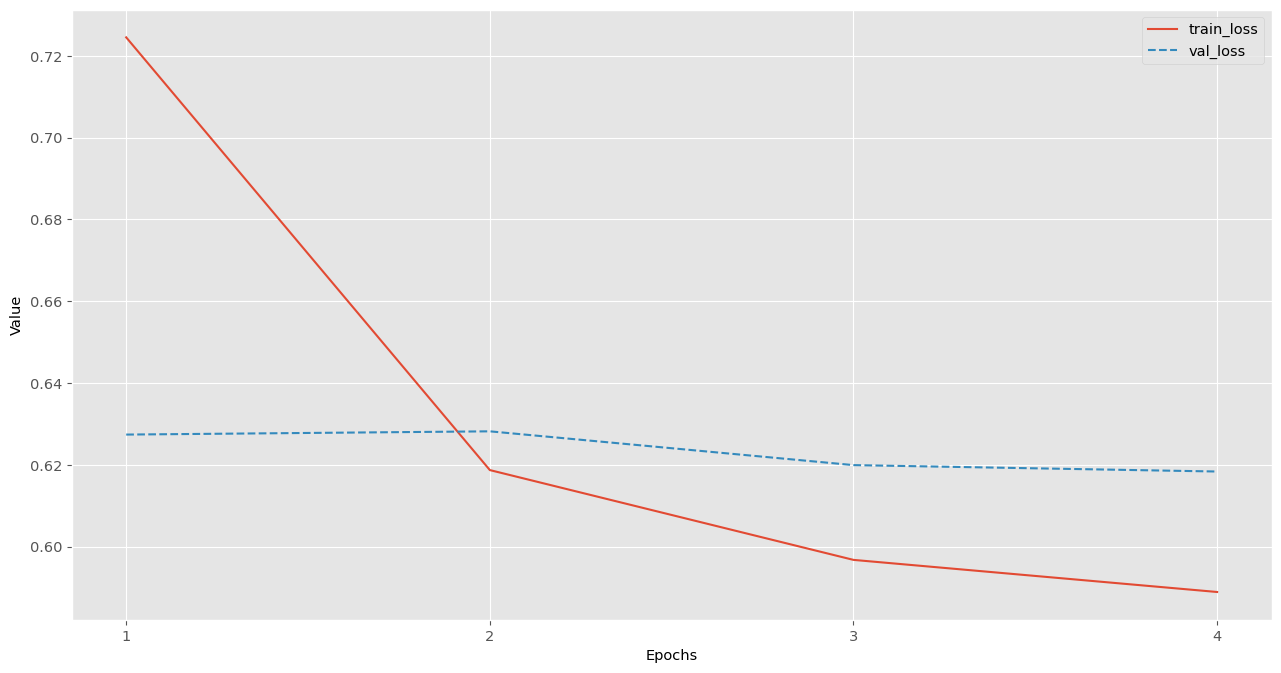

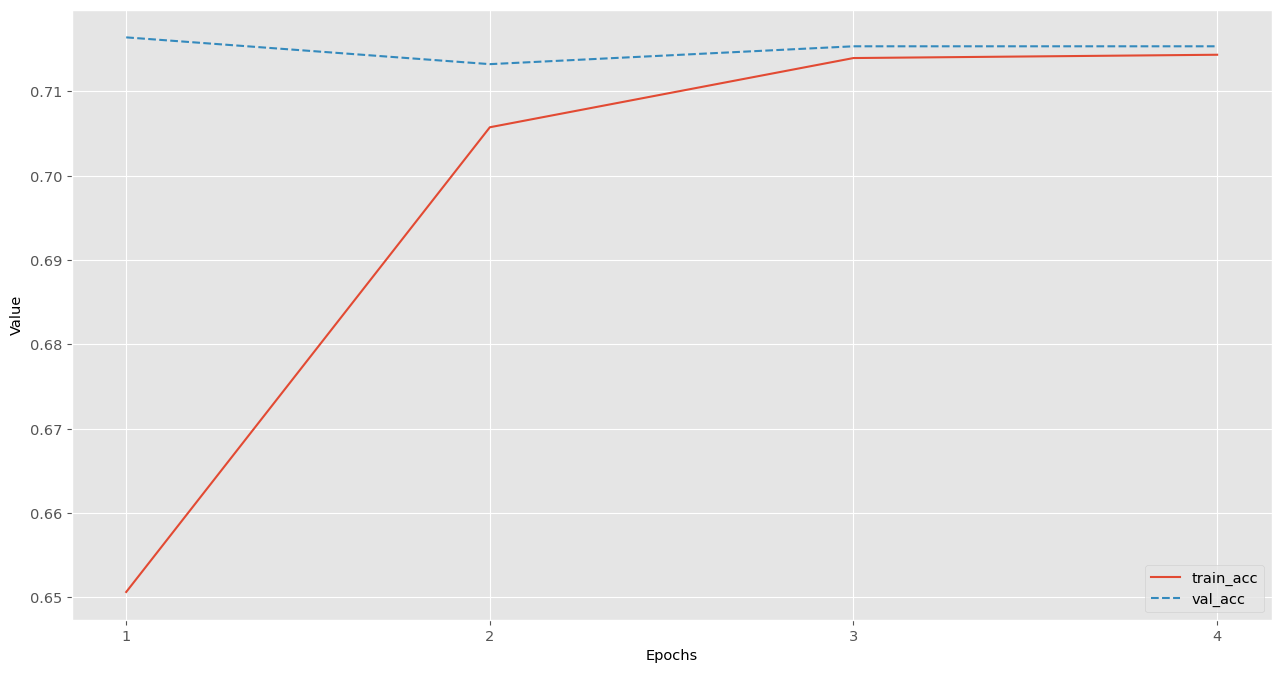

In [18]:
from torch.optim import AdamW

# ADAM = ADAPTIVE MOMENT ESTIMATION
# L'adamw è un ottimizzatore che aggiorna il modello in conseguenza della funzione 
# di perdita, in un 'Gradient descent', ad ogni epoche il loss dovrebbe scendere e trovare un MINIMO
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8)


# Il numero totale di total_steps è uguale a batch_size*epoches e
# train_dataloader contiene i dati già batched
total_steps = len(train_dataloader) * epochs

# Creiamo un learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # Default value in run_glue.py
                                            num_training_steps=total_steps)

# Salviamo la perdita media e l'accuratezza per stamparla alla fine di ogni epoches
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

# Loop per ogni epoch
print('Epoch loop ...')
for epoch in tqdm(range(epochs)):

    print('Training on batches...')
    # Facciamo un'intero addestramento sul training set
    train_labels, train_predict, train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Facciamo un'intera validazione sul validation set
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device, model)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Stampo perdita ed accuratezza per vedere come l'addestramentro sta evolvendo
    print(" train_loss: %.5f \n val_loss: %.5f \n train_acc: %.5f \n valid_acc: %.5f" % (train_loss, val_loss, train_acc, val_acc))

    # Salviamo perdita ed accuratezza per stamparla successivamente in un grafico
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Stampo la curva di perdita
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'], magnify=0.1)

# Stampo la curva di accuratezza 
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'], magnify=0.1)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.45it/s]


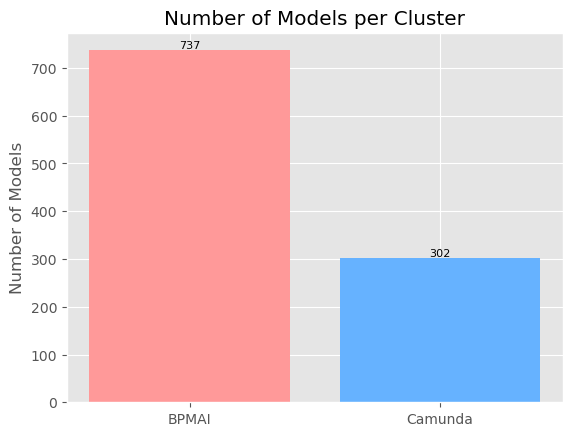

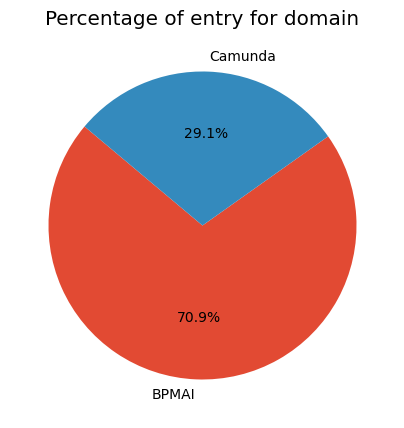

              precision    recall  f1-score   support

       BPMAI       0.71      1.00      0.83       737
     Camunda       0.67      0.01      0.01       302

    accuracy                           0.71      1039
   macro avg       0.69      0.50      0.42      1039
weighted avg       0.70      0.71      0.59      1039

Normalized confusion matrix


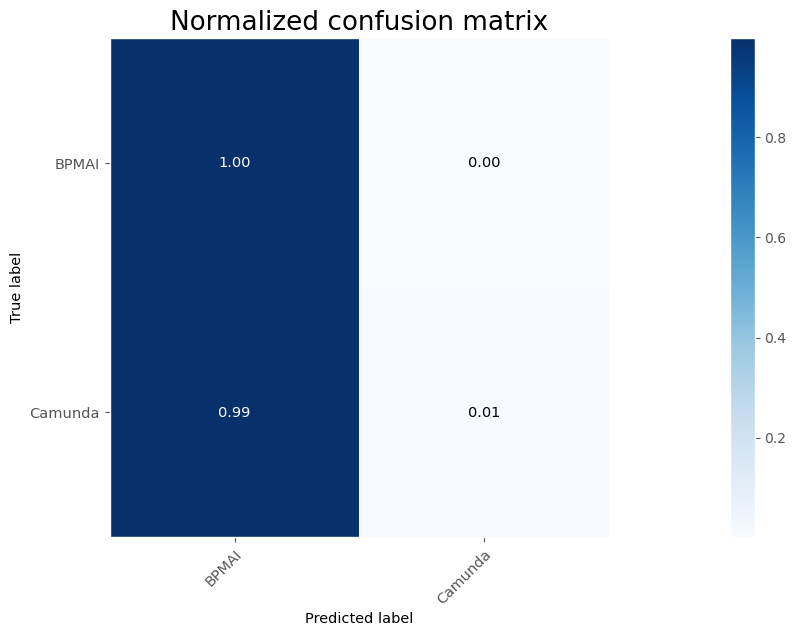

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "./BPMNtesting.csv"
%run "./support_functions.ipynb"

# Carico il file con il dataframe
df = pd.read_csv(path, sep=';', engine='python', encoding=get_file_encoding(path))

# Get prediction form model on validation data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device, model)

# Stampo il grafico con il relativo numero di righe per dominio
counts=df['CollectionName'].value_counts()
modelli_per_cluster = counts.values.tolist()
cluster_labels = df['CollectionName'].unique()
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots()
bars = ax.bar(cluster_labels, modelli_per_cluster, color=colors)
for bar, label in zip(bars, modelli_per_cluster):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval),
            ha='center', va='bottom', fontsize=8, color='black')

ax.set_ylabel('Number of Models')
ax.set_title('Number of Models per Cluster')
plt.show()

# Stampo un grafico a torta per la distribuzione
plt.figure(figsize=(5, 5))
counts.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Percentage of entry for domain')
plt.ylabel('')
plt.show()

# Creo il report di valutazione
"""
Valori per valutare l'accuratezza di un modello nella classificazione.
    Precision: Quante volte un modello EVITA di prendirre una del dominio A
    Recall: Viceversa di prima, predizione sul dominio B
    F1-Score: Se il modello precide bene sia precision e recall
"""
evaluation_report = classification_report(true_labels, predictions_labels, 
                                           labels=list(labels_ids.values()), 
                                           target_names=list(labels_ids.keys()), 
                                           zero_division=1)  # Impostato su 1 per impostare precision e F-score a 0 quando non ci sono campioni predetti

# Stampo il report di valutazione
print(evaluation_report)

# Stampo il confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );